# Shrink the number of different values of the data by introducing categories

## 1. Data

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import pylab as plot


pd.options.display.max_columns = 100
params = {
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)

In [2]:
import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv("../data/train.csv")
args.raw_test = pd.read_csv("../data/test.csv")
args.train_border_index = 891
args.val_border_index = 265
args.splits = 5

In [3]:
print(args.raw_train.shape)
args.raw_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(args.raw_test.shape)
args.raw_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Unknown data

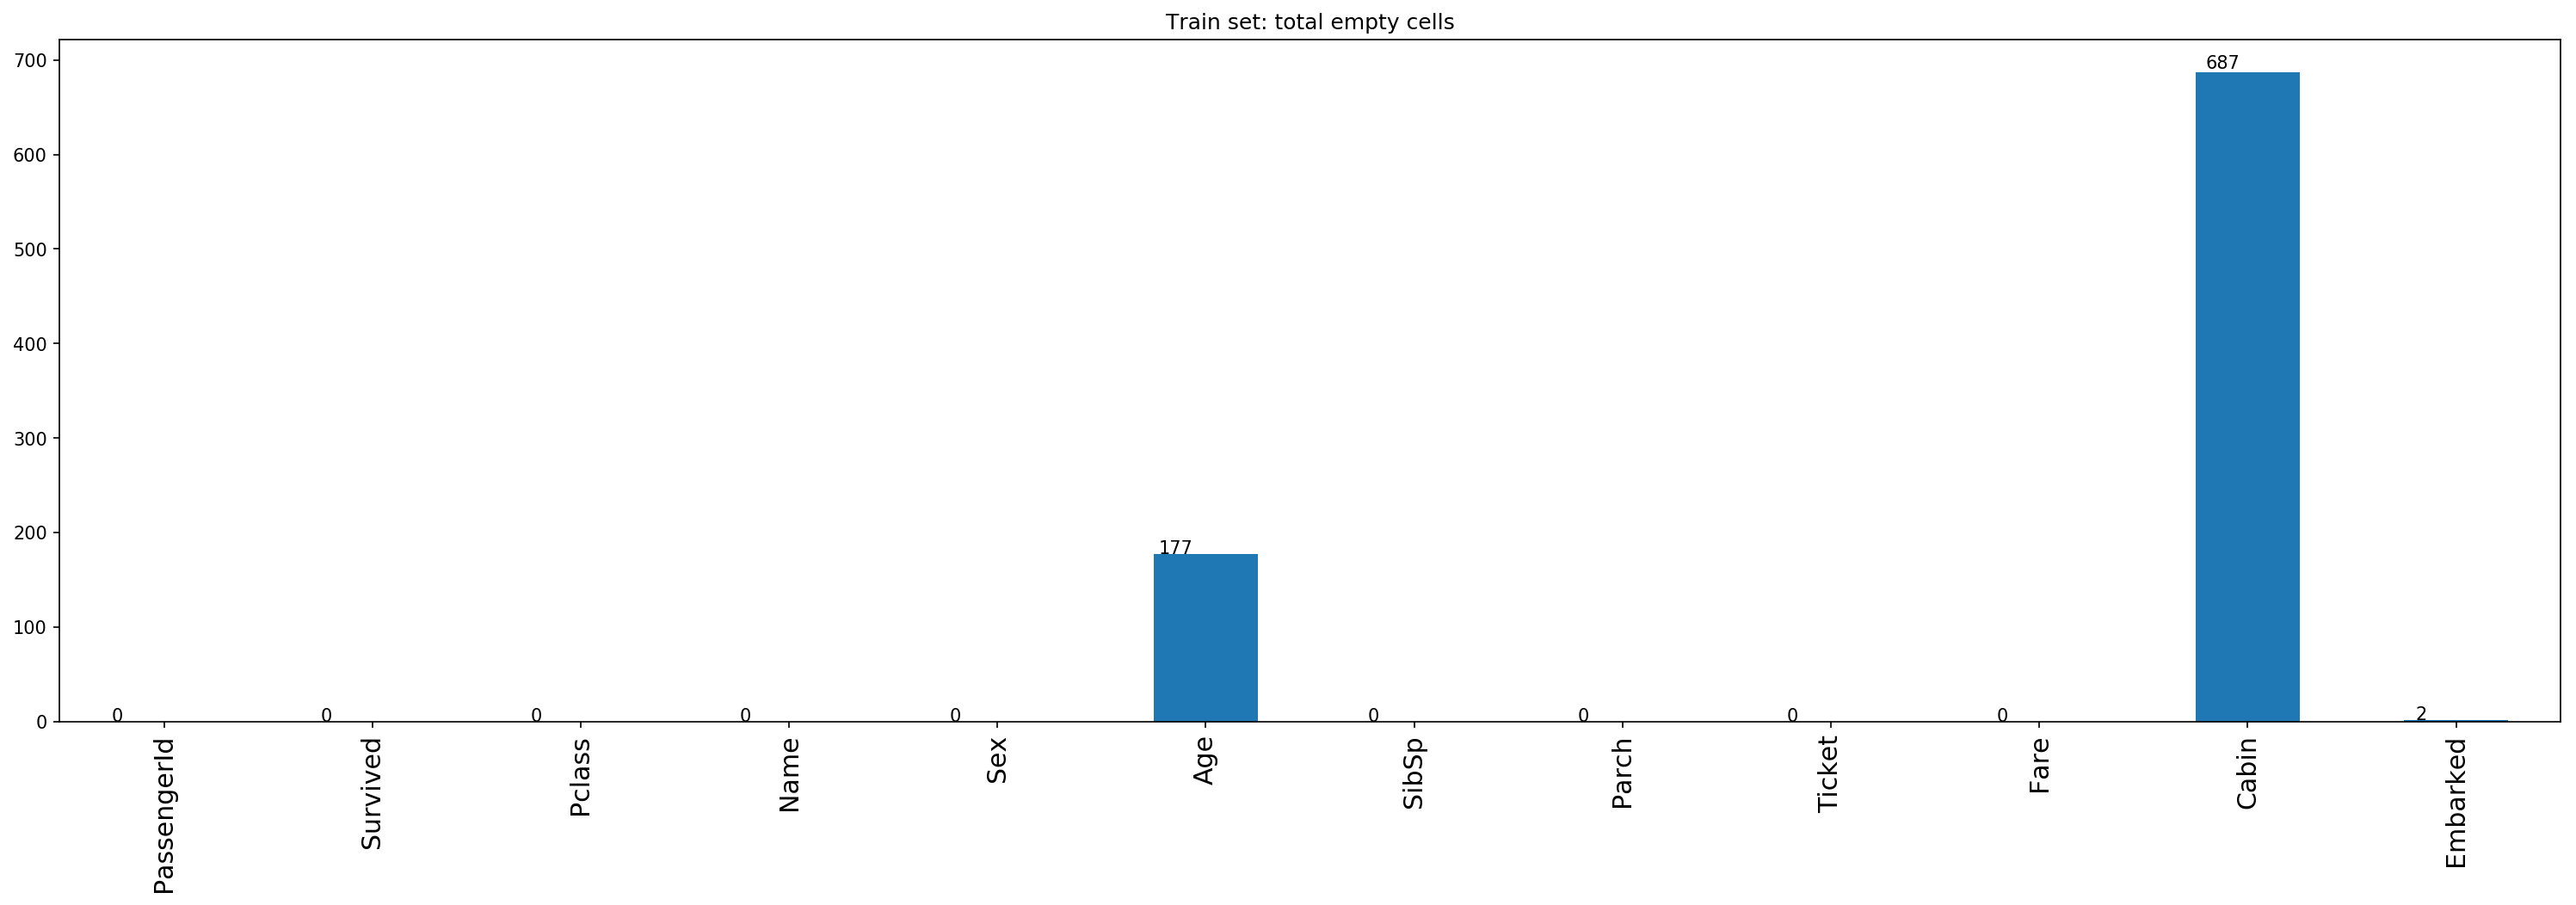

In [5]:
ax = args.raw_train.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

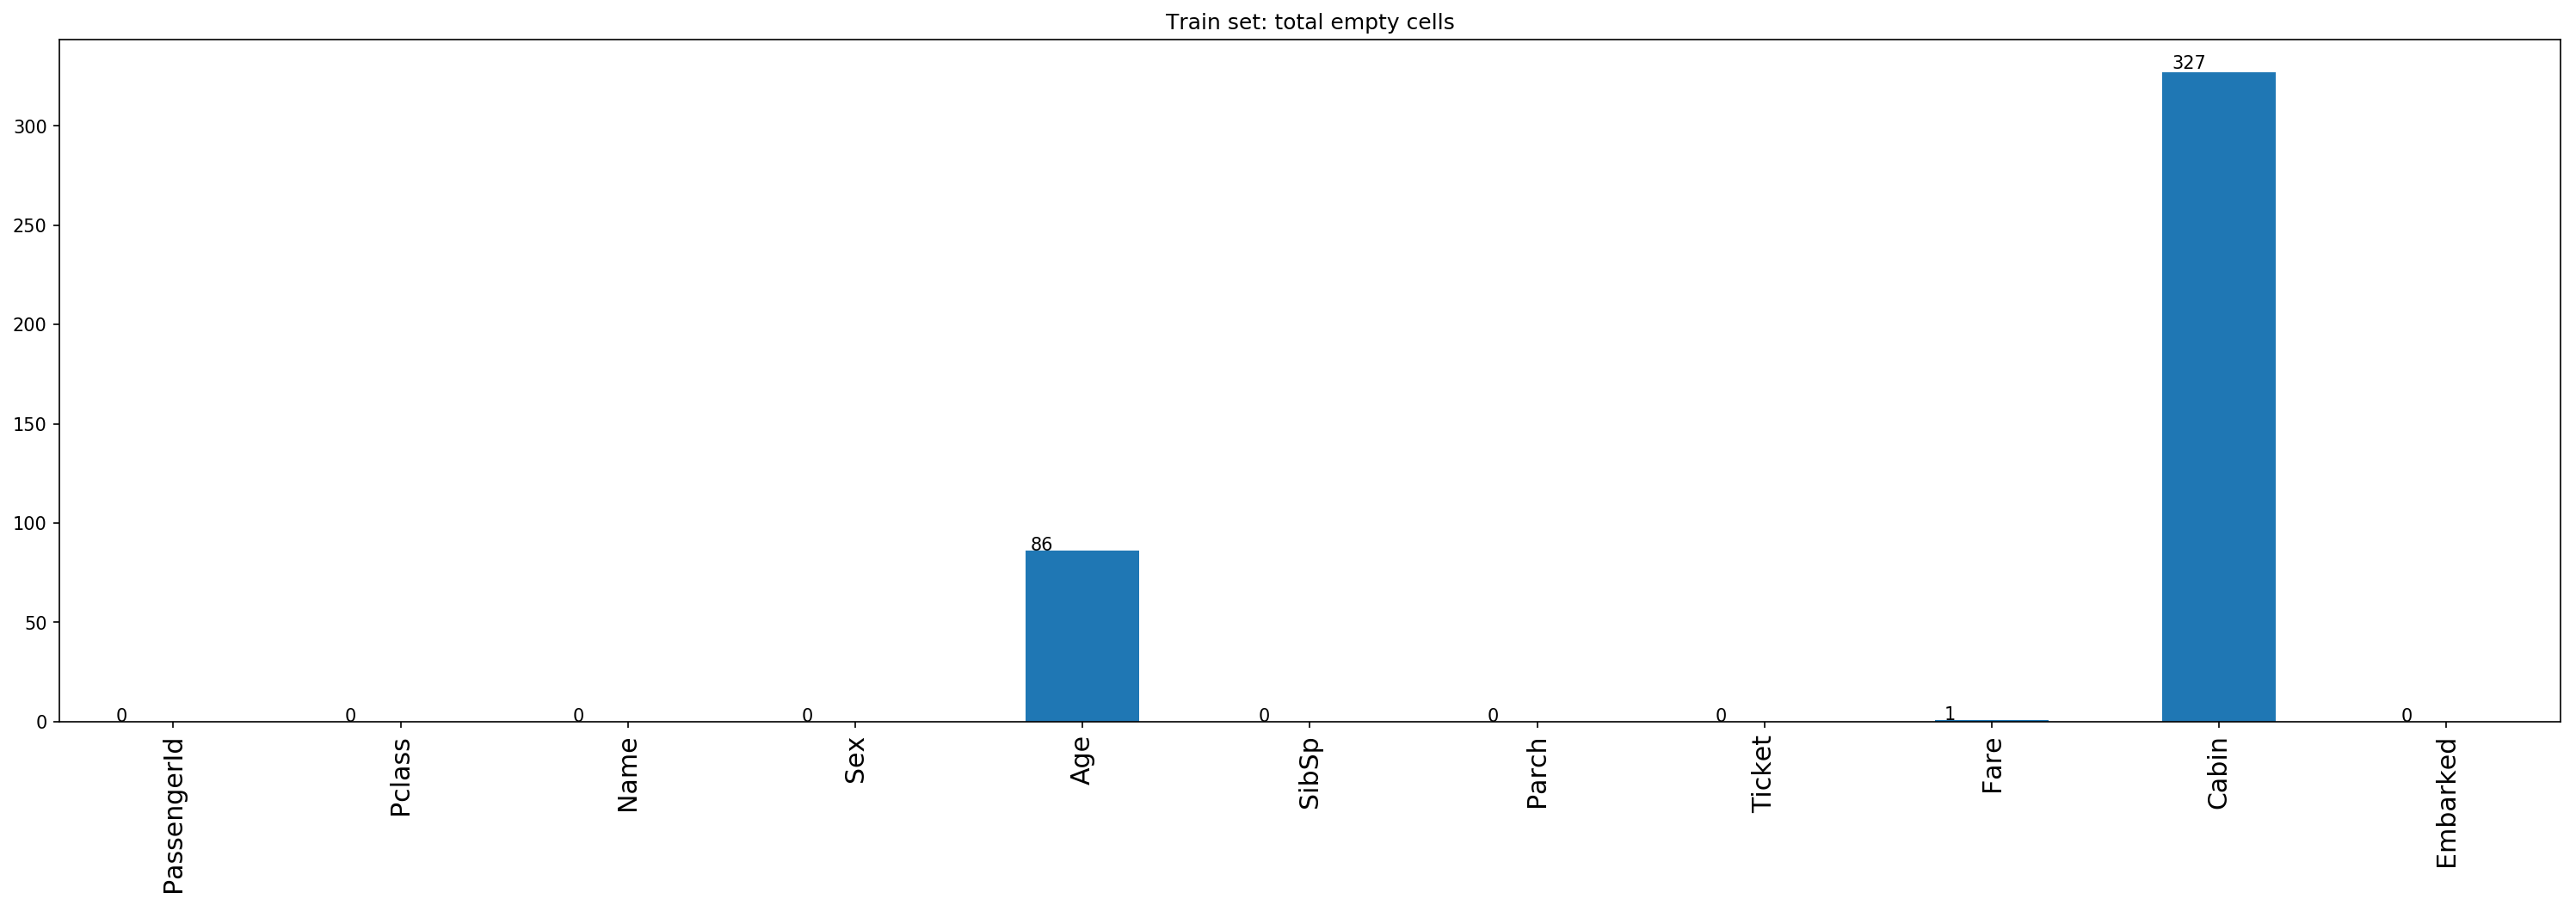

In [6]:
ax = args.raw_test.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## 2. Filling missing data

In [7]:
train = args.raw_train.copy()
test = args.raw_test.copy()

#### Cabin

In [8]:
train.drop('Cabin', axis=1, inplace=True, errors = 'ignore')
test.drop('Cabin', axis=1, inplace=True, errors = 'ignore')

#### Embarked

In [9]:
most_frequent_embarked = train['Embarked'].value_counts().index[0]
train['Embarked'] = train['Embarked'].fillna(most_frequent_embarked)
train['Embarked'].isna().sum()

0

#### Age

In [10]:
train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(test['Age'].median())
print(train['Age'].isna().sum())
test['Age'].isna().sum()

0


0

#### Fare

In [11]:
test['Fare'] = test['Fare'].fillna(test['Fare'].median())
test['Fare'].isna().sum()

0

In [12]:
args.train_filled  = train.copy()
args.test_filled  = test.copy()

## 3. Feature engineering

### Combine datasets for the same preprocessing

In [13]:
train = args.train_filled.copy()
test = args.test_filled.copy()
comb = train.append(test, ignore_index=True, sort=False)

### Remove PassengerId, Name, Ticket

In [14]:
comb.drop('PassengerId', axis=1, inplace=True, errors = 'ignore')
comb.drop('Name', axis=1, inplace=True, errors = 'ignore')
comb.drop('Ticket', axis=1, inplace=True, errors = 'ignore')

### Encode sex

In [15]:
comb['Sex'] = comb['Sex'].astype('category').cat.codes

### Encode Embarked

In [16]:
comb['Embarked'] = comb['Embarked'].astype('category').cat.codes

### MinMax Scaling

In [17]:
import pandas as pd
from sklearn import preprocessing

def min_max_scale(comb):
    temp = comb.values #a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    temp = min_max_scaler.fit_transform(temp)
    return pd.DataFrame(temp, columns=comb.columns)
comb = min_max_scale(comb)
args.comb_baseline = comb
args.comb_baseline.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,1.0,1.0,0.273456,0.125,0.0,0.014151,1.0
1,1.0,0.0,0.0,0.473882,0.125,0.0,0.139136,0.0
2,1.0,1.0,0.0,0.323563,0.000,0.0,0.015469,1.0
3,1.0,0.0,0.0,0.436302,0.125,0.0,0.103644,1.0
4,0.0,1.0,1.0,0.436302,0.000,0.0,0.015713,1.0


## 4. Data representation

In [18]:
comb_baseline = args.comb_baseline.copy()

train = comb_baseline[:args.train_border_index]
test = comb_baseline[args.train_border_index:].reset_index(drop=True)

In [19]:
X_baseline = train.drop('Survived', axis=1)
args.X_baseline = X_baseline.copy()
X_baseline.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,0.273456,0.125,0.0,0.014151,1.0
1,0.0,0.0,0.473882,0.125,0.0,0.139136,0.0
2,1.0,0.0,0.323563,0.000,0.0,0.015469,1.0
3,0.0,0.0,0.436302,0.125,0.0,0.103644,1.0
4,1.0,1.0,0.436302,0.000,0.0,0.015713,1.0


In [20]:
y_baseline = train['Survived']
args.y_baseline = y_baseline.copy()
y_baseline.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

In [21]:
x_baseline = test.drop('Survived', axis=1)
args.x_baseline = x_baseline.copy()
x_baseline.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,0.430039,0.000,0.000000,0.015282,0.5
1,1.0,0.0,0.586622,0.125,0.000000,0.013663,1.0
2,0.5,1.0,0.774521,0.000,0.000000,0.018909,0.5
3,1.0,1.0,0.336089,0.000,0.000000,0.016908,1.0
4,1.0,0.0,0.273456,0.125,0.111111,0.023984,1.0


### 4.1 PCA

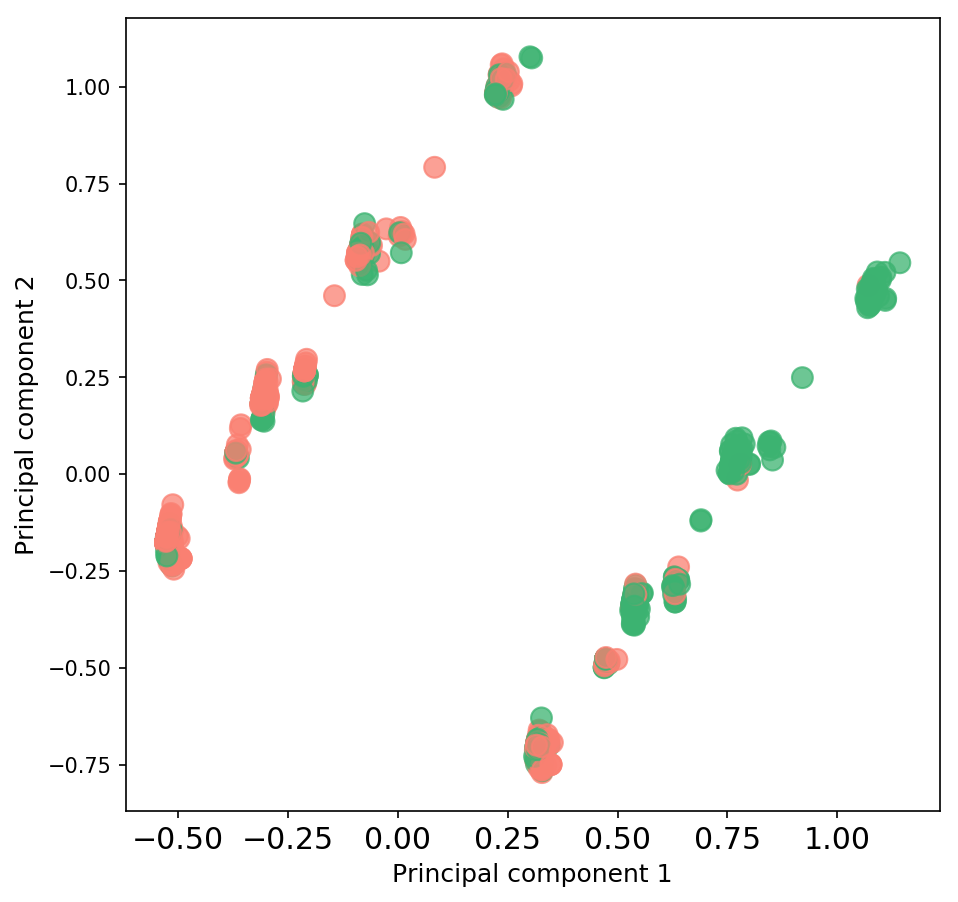

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_full_transformed = pca.fit_transform(X_baseline)
X_train_full_transformed = pd.DataFrame(data=X_train_full_transformed[:, :], 
                                        columns=['Principal component 1', 'Principal component 2'])
y_train_full_color = y_baseline.copy()
y_train_full_color[y_train_full_color==0] = 'Salmon'
y_train_full_color[y_train_full_color==1] = 'MediumSeaGreen'
X_train_full_transformed.plot(kind='scatter', x=X_train_full_transformed.columns[0], 
                              y=X_train_full_transformed.columns[1], figsize=(7, 7), s=100,
                              color=y_train_full_color, alpha=0.75)

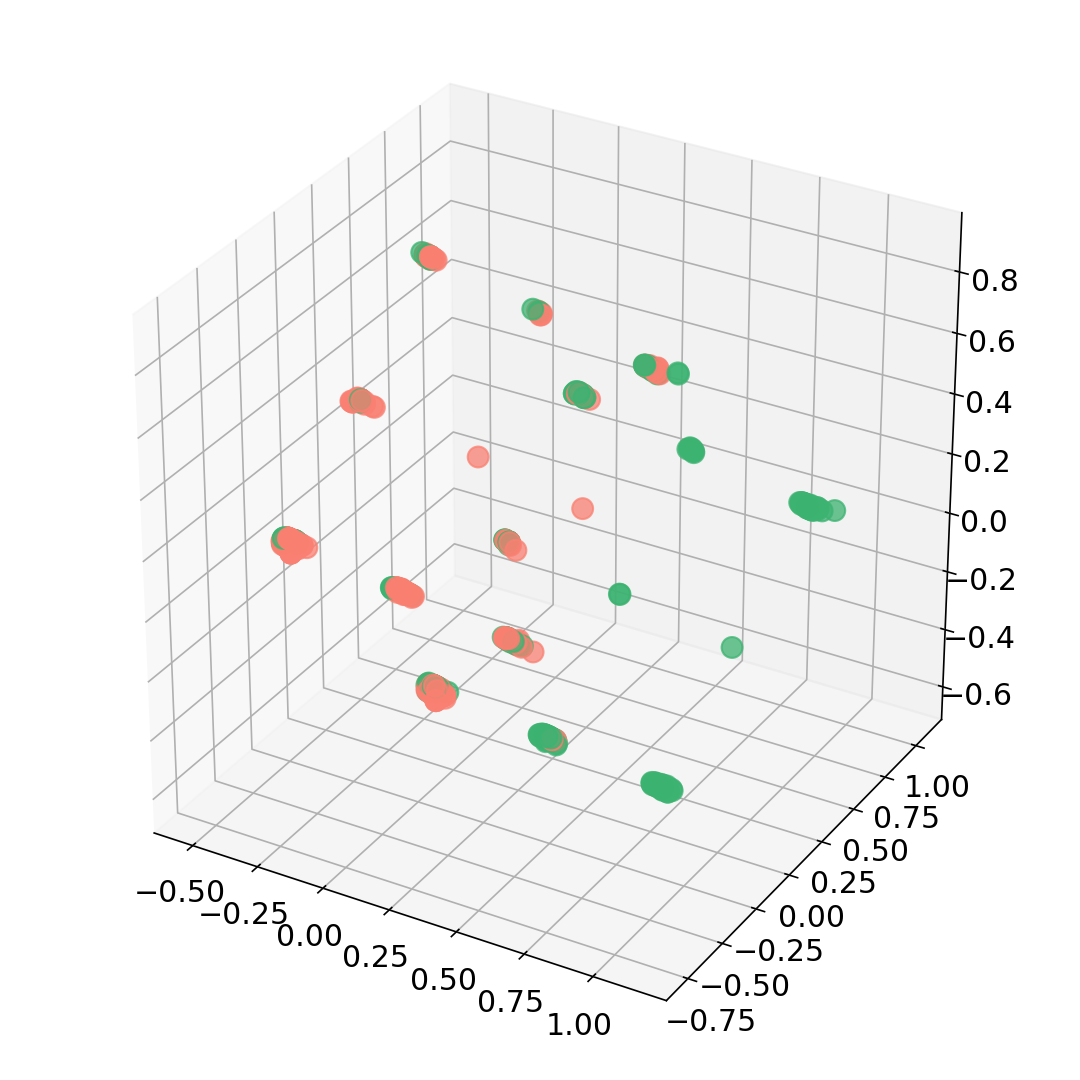

In [23]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  

pca = PCA(n_components=3)
X_train_full_transformed = pca.fit_transform(X_baseline)

y_train_full_color = y_baseline.copy()
y_train_full_color[y_train_full_color==0] = 'Salmon'
y_train_full_color[y_train_full_color==1] = 'MediumSeaGreen'

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)
ax.scatter(X_train_full_transformed[:, 0], X_train_full_transformed[:, 1], X_train_full_transformed[:, 2], 
           color=y_train_full_color, s=100, alpha=0.75)

### 4.2 LDA

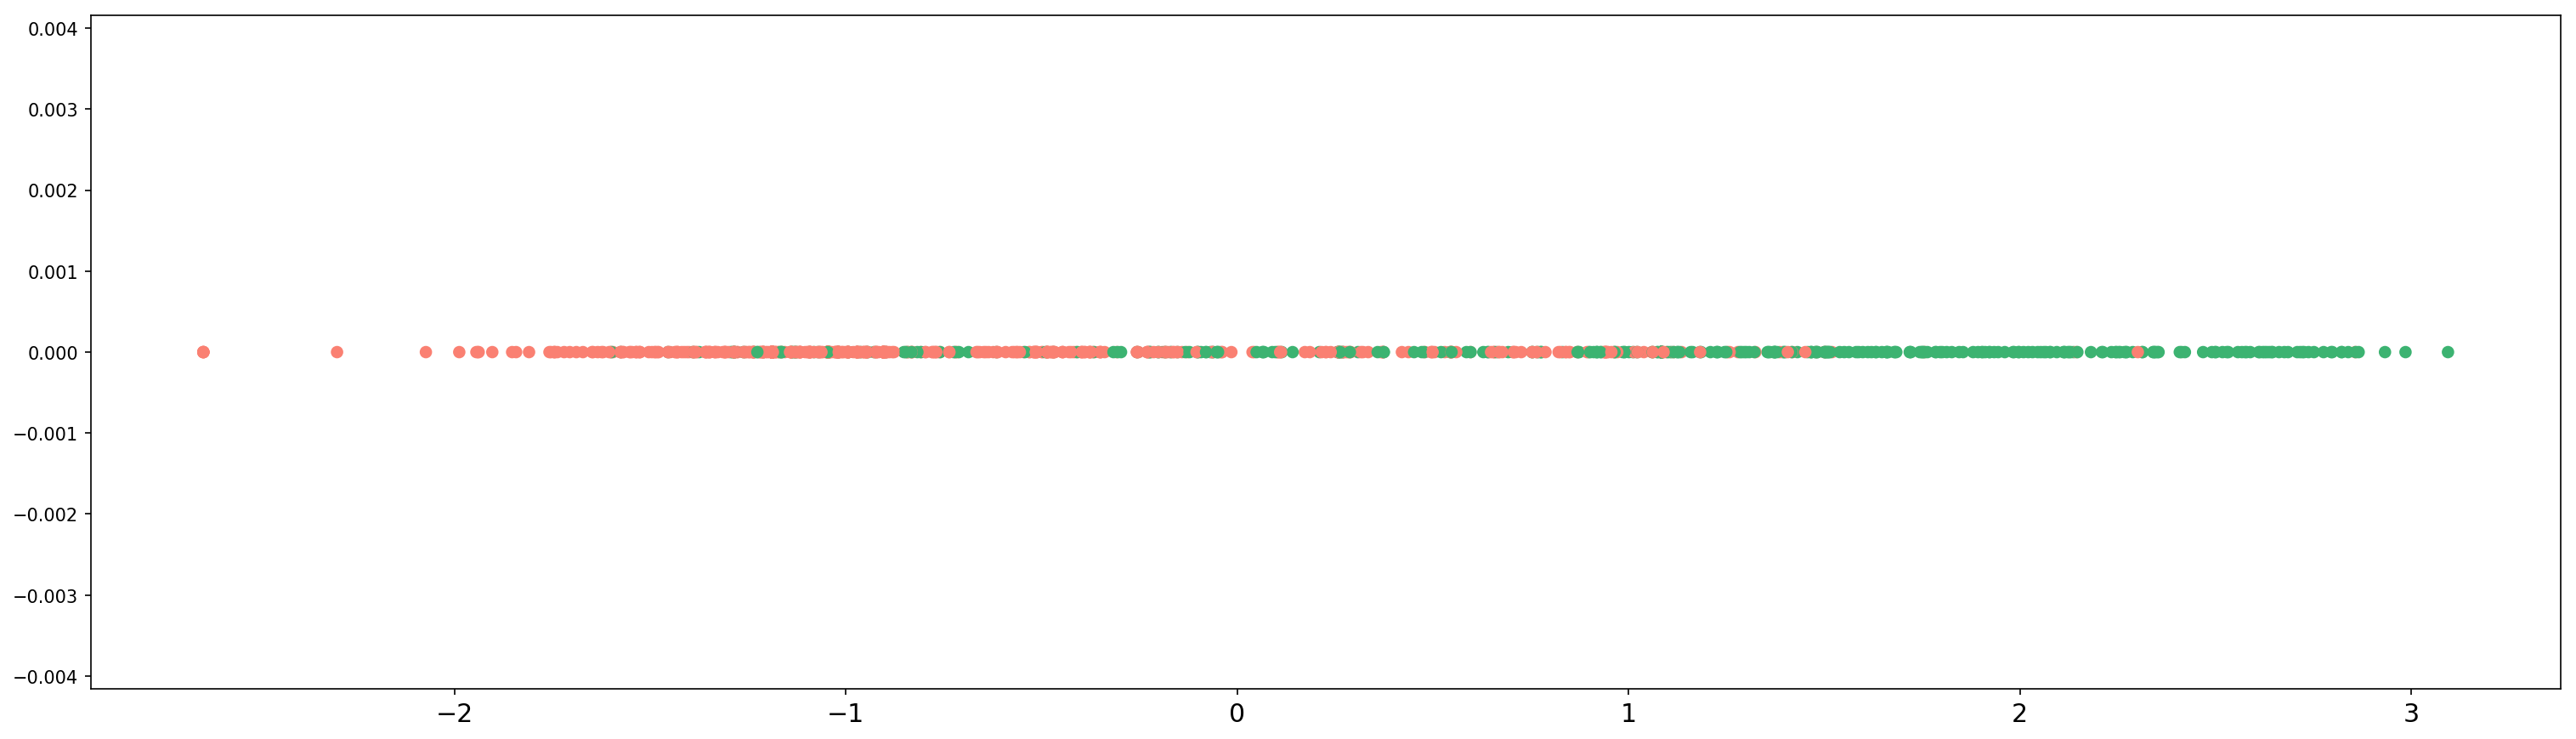

In [24]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
X_train_full_transformed = clf.fit_transform(X_baseline, y_baseline)

y_train_full_color = y_baseline.copy()
y_train_full_color[y_train_full_color==0] = 'Salmon'
y_train_full_color[y_train_full_color==1] = 'MediumSeaGreen'

plt.scatter(X_train_full_transformed, np.zeros(X_train_full_transformed.shape), c=y_train_full_color)

## 5. Training

### Extra trees

In [25]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

def predict_extra_trees(X, y, x, splits=args.splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=17)
    parameters = {'n_estimators': [2, 5, 10, 25, 50, 100, 250, 500],
                  'max_depth': [1, 2, 5, 7, 10, 15, 20, 50, 100, None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 10,
                                                                                              15]}
    classifier = ExtraTreesClassifier(random_state=42)
    gcv = GridSearchCV(classifier, parameters, n_jobs=-1, cv=skf, verbose=1)
    gcv.fit(X, y)
    best_params = gcv.best_params_
    print('ExtraTrees best params: ' + repr(gcv.best_params_))
    print('ExtraTrees best CV score: ' + repr(gcv.best_score_))
    
    classifier = ExtraTreesClassifier(**best_params, random_state=42)
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return predictions.astype(int)

### Random forest

In [26]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def predict_random_forest(X, y, x, splits=args.splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=17)
    parameters = {'n_estimators': [25, 50, 75, 100, 150, 200, 500], 'max_features': [2, 3, 4, 5, 6, 7],
                  'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5, 10, 15, 20]}
    rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=False)
    gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
    gcv.fit(X, y)
    best_params = gcv.best_params_
    print('RandomForest best params: ' + repr(gcv.best_params_))
    print('RandomForest best CV score: ' + repr(gcv.best_score_))
    
    classifier = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1, oob_score=False)
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return predictions.astype(int)

### Multilayer perceptron

In [27]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier

def predict_mlp(X, y, x, splits=args.splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=17)
    parameters = {'hidden_layer_sizes': [(512, ), (128, ), (16, ), (512, 64, ), (128, 16), (16, 4)],
                  'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 'max_iter': [50, 100, 200, 400, 750, 1000],
                  'early_stopping': [False, True]}
    classifier = MLPClassifier(random_state=42)
    gcv = GridSearchCV(classifier, parameters, n_jobs=-1, cv=skf, verbose=3)
    gcv.fit(X, y)
    best_params = gcv.best_params_
    print('MLP best params: ' + repr(gcv.best_params_))
    print('MLP best CV score: ' + repr(gcv.best_score_))
    
    classifier = MLPClassifier(**best_params, random_state=42)
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return predictions.astype(int)

### XGBoost

In [28]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

def predict_xgboost(X, y, x, splits=args.splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=17)
    parameters = {'n_estimators': [2, 5, 10, 25, 50, 100, 250, 500], 'max_depth': [1, 2, 3, 4, 5, 7, 10, 15, 20, 50],
                  'learning_rate': [0.001, 0.01, 0.1, 0.5, 1], 'booster': ['gbtree', 'gblinear', 'dart']}
    classifier = XGBClassifier()
    gcv = GridSearchCV(classifier, parameters, n_jobs=-1, cv=skf, verbose=1)
    gcv.fit(X, y)
    best_params = gcv.best_params_
    print('XGBoost best params: ' + repr(gcv.best_params_))
    print('XGBoost best CV score: ' + repr(gcv.best_score_))
    
    classifier = XGBClassifier(**best_params)
    classifier.fit(X, y)
    print('XGBoost feature importance: ' + repr(classifier.feature_importances_))
    predictions = classifier.predict(x)
    return predictions.astype(int)

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/glaizier/github/titanic-prediction/.venv/lib/python3.7/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/glaizier/github/titanic-prediction/.venv/lib/python3.7/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


### SVM

In [29]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

def predict_svm(X, y, x, splits=args.splits):
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=17)
    parameters = {'C': [0.01, 0.1, 1, 10, 50], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
    classifier = SVC(random_state=42, kernel='linear')
    gcv = GridSearchCV(classifier, parameters, n_jobs=-1, cv=skf, verbose=3)
    gcv.fit(X, y)
    best_params = gcv.best_params_
    print('SVM best params: ' + repr(gcv.best_params_))
    print('SVM best CV score: ' + repr(gcv.best_score_))
    
    classifier = SVC(**best_params, random_state=42, kernel='linear')
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return predictions.astype(int)

In [30]:
def csv_predictions(predictions, filename):
    submission = pd.DataFrame({'PassengerId': args.raw_test['PassengerId'],'Survived': predictions})

    submission.to_csv(filename, index=False)
    print('Saved file: ' + filename)

## 6. Baseline solution with the best baseline model with better params

In [ ]:
predictions = predict_xgboost(X_baseline, y_baseline, x_baseline)
csv_predictions(predictions, 'titanic-approach2-baseline-xgboost.csv')

## 7. Thorough feature engineering to improve the model's accuracy

In [ ]:
train  = args.train_filled.copy()
test  = args.test_filled.copy()

comb = train.append(test, ignore_index=True, sort=False)
comb.head()

### Transform name to title

In [ ]:
title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir": "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess": "Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Royalty"
}
# map name to title
comb['Title'] = comb['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip()).map(title_dictionary)

# set a single value to Royalty manually
comb.loc[comb[comb['Title'].isnull()].index[0], 'Title'] = 'Royalty'
comb.drop('Name', axis=1, inplace=True)

### Filling NA ages more carefully taking account of sex, pclass and title

In [ ]:
# get back the initial values for Age with nans
train_raw_ages = args.raw_train['Age']
test_raw_ages = args.raw_test['Age']
comb_raw_ages = train_raw_ages.append(test_raw_ages, ignore_index=True)
comb.drop('Age', axis=1, inplace=True, errors='ignore')
comb = pd.concat([comb, comb_raw_ages], axis=1)


def fill_age_median(comb):
    median_ages = comb.groupby(['Sex', 'Pclass', 'Title']).median().reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
    def fill_age_median_row(row):
        if np.isnan(row['Age']):
            return median_ages[(median_ages['Sex'] == row['Sex']) 
                              & (median_ages['Pclass'] == row['Pclass']) 
                              & (median_ages['Title'] == row['Title'])]['Age'].values[0]
        return row['Age']
    comb['Age'] = comb.apply(lambda row: fill_age_median_row(row), axis=1)
    
fill_age_median(comb)

### Remove PassengerId

In [ ]:
comb.drop('PassengerId', axis=1, inplace=True, errors = 'ignore')

### Encode sex

In [ ]:
comb['Sex'] = comb['Sex'].astype('category').cat.codes

### Encode Embarked

In [ ]:
comb['Embarked'] = comb['Embarked'].astype('category').cat.codes

dummies = pd.get_dummies(comb['Embarked'], prefix='Embarked')
comb = pd.concat([comb, dummies], axis=1)
comb.drop('Embarked', axis=1, inplace=True)

### Encode Pclass

In [ ]:
comb['Pclass'] = comb['Pclass'].astype('category').cat.codes + 1

### Encode ticket

In [ ]:
import re

def clean_ticket(ticket):
    # replace all special chars
    ticket = re.sub('[^a-zA-Z0-9]', '', ticket)
    if ticket[0].isdigit():
        return 'digit'
    return ticket[0]

comb['Ticket'] = comb['Ticket'].map(clean_ticket).astype('category').cat.codes

dummies = pd.get_dummies(comb['Ticket'], prefix='Ticket')
comb = pd.concat([comb, dummies], axis=1)
comb.drop('Ticket', axis=1, inplace=True)

### Encode title

In [ ]:
comb['Title'] = comb['Title'].astype('category').cat.codes

dummies = pd.get_dummies(comb['Title'], prefix='Title')
comb = pd.concat([comb, dummies], axis=1)
comb.drop('Title', axis=1, inplace=True)

### Transform the number of parents and siblings to family size

In [ ]:
def fill_family_size(comb, s_size=0, m_size=4):
    def fill_family_size_row(row):
        if row['SibSp'] + row['Parch'] == s_size:
            return 's'
        elif row['SibSp'] + row['Parch'] <= m_size:
            return 'm'
        else:
            return 'l'
    comb['FamilySize'] = comb.apply(lambda row: fill_family_size_row(row), axis=1)
    
fill_family_size(comb)
comb['FamilySize'] = comb['FamilySize'].astype('category').cat.codes
comb.drop('SibSp', axis=1, inplace=True, errors = 'ignore')
comb.drop('Parch', axis=1, inplace=True, errors = 'ignore')


dummies = pd.get_dummies(comb['FamilySize'], prefix='FamilySize')
comb = pd.concat([comb, dummies], axis=1)
comb.drop('FamilySize', axis=1, inplace=True)

### Age to age categories

In [ ]:
def categorise_age(comb):
    def categorise_age_row(row):
        def get_age_category(age):
            return {
                    age < 16: 1,
                    16 <= age < 32: 2,
                    32 <= age < 48: 3,
                    48 <= age < 64: 4,
                    64 <= age: 5
            }[True]
        return get_age_category(row['Age'])
    comb['AgeCategory'] = comb.apply(lambda row: categorise_age_row(row), axis=1)
    
categorise_age(comb)
comb.drop('Age', axis=1, inplace=True, errors = 'ignore')

### Fare to fare category

In [ ]:
def categorise_fare(comb):
    def categorise_fare_row(row):
        def get_fare_category(fare):
            return {
                    fare < 25: 1,
                    25 <= fare < 50: 2,
                    50 <= fare < 100: 3,
                    100 <= fare < 200: 4,
                    200 <= fare: 5
            }[True]
        return get_fare_category(row['Fare'])
    comb['FareCategory'] = comb.apply(lambda row: categorise_fare_row(row), axis=1)
    
categorise_fare(comb)
comb.drop('Fare', axis=1, inplace=True, errors = 'ignore')

dummies = pd.get_dummies(comb['FareCategory'], prefix='FareCategory')
comb = pd.concat([comb, dummies], axis=1)
comb.drop('FareCategory', axis=1, inplace=True)

### Introducing age category * pclass

In [ ]:
comb['AgeCategory*Pclass'] = comb.apply(lambda row: int(row['AgeCategory'] * row['Pclass']), axis=1)

dummies = pd.get_dummies(comb['AgeCategory*Pclass'], prefix='AgeCategory*Pclass')
comb = pd.concat([comb, dummies], axis=1)
comb.drop('AgeCategory*Pclass', axis=1, inplace=True)

In [ ]:
dummies = pd.get_dummies(comb['AgeCategory'], prefix='AgeCategory')
comb = pd.concat([comb, dummies], axis=1)
comb.drop('AgeCategory', axis=1, inplace=True)

dummies = pd.get_dummies(comb['Pclass'], prefix='Pclass')
comb = pd.concat([comb, dummies], axis=1)
comb.drop('Pclass', axis=1, inplace=True)

## 8. Training all the available data representations

In [ ]:
train = comb[:args.train_border_index]
X = train.drop('Survived', axis=1)
y = train['Survived']
test = comb[args.train_border_index:].reset_index(drop=True)
x = test.drop('Survived', axis=1)
args.X = X.copy()
args.y = y.copy()
args.x = x.copy()

In [ ]:
X.head()

### Extra trees

In [ ]:
predictions = predict_extra_trees(X, y, x)
csv_predictions(predictions, 'titanic-approach3-extra-trees.csv')

### Random forest

In [ ]:
predictions = predict_random_forest(X, y, x)
csv_predictions(predictions, 'titanic-approach3-random-forest.csv')

### MLP

In [ ]:
predictions = predict_mlp(X, y, x)
csv_predictions(predictions, 'titanic-approach3-mlp.csv')

### XGBoost

In [ ]:
predictions = predict_xgboost(X, y, x)
csv_predictions(predictions, 'titanic-approach3-xgboost.csv')

### SVM

In [ ]:
predictions = predict_svm(X, y, x)
csv_predictions(predictions, 'titanic-approach3-svm.csv')

### CV models' scores
#### With Parch and SibSp

|  Model | CV score |
|---|---|
| Extra trees  |  82.828% |
| Random forest | 83.277%|
| MLP | 82.603% |
| XGBoost | 82.941% |
| SVM | 78.676% |

### Test set accuracies 
These results are a matter of luck since initial model params and K-Fold split might vary from time to time. In the 3rd column the params with which the test score was reached are present. 

#### With Parch and SibSp

|  Model | Test set score | Params |
|---|---|---|
| Extra trees  |  79.904% | {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 500} |
| Random forest | 79.425%| {'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 150} |
| MLP | 79.425% | {'alpha': 1, 'early_stopping': False, 'hidden_layer_sizes': (128,), 'max_iter': 50} |
| XGBoost | 78.947% | {'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} |
| SVM | 76.555% | {'C': 0.1, 'gamma': 0.0001} |

## 9. Bagging the best models

In [ ]:
predictions1 = pd.read_csv('titanic-approach3-extra-trees.csv')
predictions2 = pd.read_csv('titanic-approach3-random-forest.csv')
predictions3 = pd.read_csv('titanic-approach3-mlp.csv')

def calc_models_correlation(predictions):
    np_predictions = [prediction['Survived'].values for prediction in predictions]
    res = pd.DataFrame(0, index=np.arange(predictions[0]['Survived'].size), columns=['Survived'])
    for prediction in predictions:
        res['Survived'] = res['Survived'] + prediction['Survived']
    res['Survived'] = res['Survived'].map(lambda val: 1 if (val == 0 or val == len(predictions)) else 0)
    res['Survived'].sum()
    return res['Survived'].sum() / res['Survived'].size
print(calc_models_correlation([predictions1, predictions2])) 
print(calc_models_correlation([predictions1, predictions3]))
print(calc_models_correlation([predictions2, predictions3]))

In [ ]:
def predict_bag_models(predictions):
    res = pd.DataFrame(0, index=np.arange(predictions[0]['Survived'].size), columns=['Survived'])
    for prediction in predictions:
        res['Survived'] = res['Survived'] + prediction['Survived']
    res['Survived'] = res['Survived'].map(lambda val: 1 if val / len(predictions) > 0.5 else 0)
    return res['Survived'].values
    
predictions_bag_models = predict_bag_models([predictions1, 
                                             predictions2,
                                             predictions3])
csv_predictions(predictions_bag_models, 'titanic-approach3-bag-models.csv')

### Test set accuracies with the usage of bagging of the best models
These results are a matter of luck since initial model params and K-Fold split might vary from time to time.

|  Model | Test set score |
|---|---|
| Extra trees + MLP + Random Forest | 79.425% |